# Imports

In [121]:
import numpy as np
import pandas as pd
from scipy import sparse
import scipy.linalg as spla

import multiprocessing
from multiprocessing import process
from multiprocessing import Pool 

import time
import itertools
import math
import random

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

# Declarations

In [122]:
random_seed = 42
regression_matrix_rows = 1000
regression_matrix_cols = 840
density = 0.1

# fix the random seed
np.random.seed(random_seed)

# get the matrices
A = np.random.uniform(0, 1, size=(regression_matrix_rows, regression_matrix_cols))
z = sparse.random(regression_matrix_cols, 1, density=0.01).toarray()
w = np.random.uniform (0,  0.2, size=(regression_matrix_rows, 1))
b = np.matmul(A, z) + w

print(f"Shape of A: {A.shape}\nShape of B: {b.shape} ")

Shape of A: (1000, 840)
Shape of B: (1000, 1) 


# Store Data to Compare

In [123]:
df_1 = pd.DataFrame(
    columns=["Number of Agents", "Stage", "SD"]
)

df_2 = pd.DataFrame(
    columns=["Number of Agents", "Time", "Required Stages"]
)

# Helper Functions

In [124]:
def subproblem(A, b):
    x = np.matmul((np.linalg.pinv(A)), b)
    r = b - np.matmul(A, x)
    
    return (x, r)


def processed_wrapped_parameters(args):
    return subproblem(*args)


def update_x_and_R(x, ret):
    sm = sum([tup[1] for tup in ret])
    R = [sm] * len(ret)
    
    new_x = []
    for i, j in zip(x, ret):
        if type(i) == int:
            new_x.append(j[0])
        else:
            new_x.append(i + j[0])
            
    return new_x, R


def formulate_x(x):
    new_x = []
    
    for element in x:
        new_x.append(element.tolist())
        
    flattened = list(itertools.chain.from_iterable(new_x))
    
    return list(itertools.chain.from_iterable(flattened))


def calculate_squared_distance(r):
    r = list(itertools.chain.from_iterable(r))
    
    return math.sqrt(sum([i*i for i in r]))

# Implement PRP

In [125]:
def PRP(A, b, p):
    A = np.split(A, p, axis=1)
    b = [b/p for i in range(p)]
    x = [0] * p
    w = 1/p
    R = [i for i in b]
    threshold = 0.55
    
    stage = 0
    
    while True:
        new_R = [i*w for i in R]
        
        # multiprocessing part
        parameters_list = [[i, j] for i, j in zip(A, new_R)]
        pool = Pool(p)
        ret = pool.map(processed_wrapped_parameters, parameters_list)
        pool.close()
        pool.join()
        
        x, R = update_x_and_R(x, ret)
        sd = calculate_squared_distance(R)
        df_1.loc[len(df_1)] = [p, stage, sd]
        
        if stage % 1000 == 0:
            print(f"For P={p}: SD={sd} Stage={stage}")
        if sd < threshold:
            break
            
        stage += 1 
        
    x = formulate_x(x)
    
    return x, sd, stage 

# Generate Graphs

In [126]:
def generate_graphs(df1, df2):
    grouped_df = df1.groupby("Number of Agents")
    
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of Stages", fontsize=18)
    plt.ylabel("R", fontsize=18)
    for name, group in grouped_df:
        plt.plot(group["Stage"].values, group["SD"].values, label=name)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of Agents", fontsize=18)
    plt.ylabel("Time", fontsize=18)
    plt.plot(df2["Number of Agents"].values, df2["Time"].values, color='r')
    plt.show()

# PRP Untill Converges 

In [127]:
p = [3, 4, 5, 6]

for pools in tqdm(p):
    start = time.time()
    x, sd, stage = PRP(A, b, pools)
    end = time.time()
    
    df_2.loc[len(df_2)] = [pools, end-start, stage]

  0%|          | 0/4 [00:00<?, ?it/s]

For P=3: SD=5.107338197845392 Stage=0


 25%|██▌       | 1/4 [00:12<00:36, 12.29s/it]

For P=4: SD=5.2161928022545725 Stage=0


 50%|█████     | 2/4 [00:24<00:24, 12.00s/it]

For P=5: SD=5.167070948392731 Stage=0


 75%|███████▌  | 3/4 [00:33<00:10, 10.95s/it]

For P=6: SD=4.981737712281744 Stage=0


100%|██████████| 4/4 [00:41<00:00, 10.42s/it]


In [128]:
display(df_1)
display(df_2)

,Number of Agents,Stage,SD
0,3.0,0.0,5.107338
1,3.0,1.0,3.498573
2,3.0,2.0,2.705579
3,3.0,3.0,2.233014
4,3.0,4.0,1.919461
...,...,...,...
291,6.0,52.0,0.563390
292,6.0,53.0,0.559140
293,6.0,54.0,0.555049
294,6.0,55.0,0.551109


,Number of Agents,Time,Required Stages
0,3.0,12.285934,90.0
1,4.0,11.803327,74.0
2,5.0,9.691239,72.0
3,6.0,7.873893,56.0


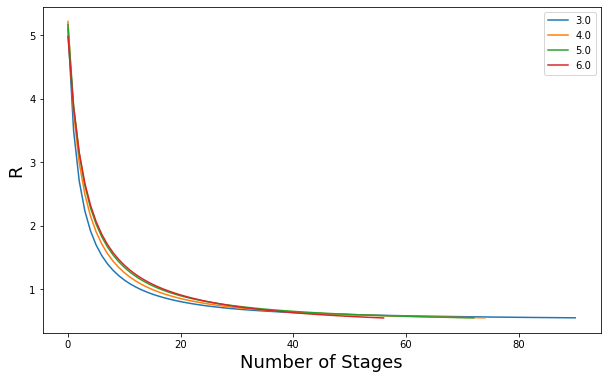

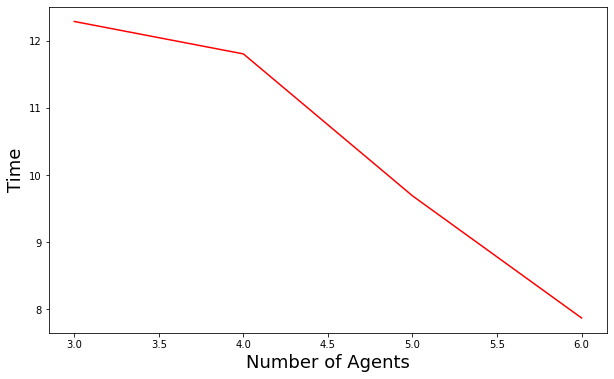

In [129]:
generate_graphs(df_1, df_2)

# RRP

In [150]:
# Declarations for RRP

threshold = 500
A_root_squared_sum_full = np.sqrt(np.sum([i*i for j in A for i in j]))

def weight_calculation(i):
    total = np.sqrt(np.sum([j*j for j in A[:, i]]))
    return total / A_root_squared_sum_full

def calculate_delta(r, I):
    dot_product = np.dot(A[:, I], r)[0]
    squared_root_sum = np.sqrt(np.sum([j*j for j in A[:, I]]))
    return (dot_product / squared_root_sum)
    
x0 = np.random.uniform (0,  1, size=(A.shape[1], 1))
list_of_col_number = [i for i in range(A.shape[1])]
weights_to_chose_a_column = [weight_calculation(i) for i in range(A.shape[1])]

In [151]:
def rrp(A, x0):
    x = x0
    r = b - np.matmul(A, x)
    
    cnt = 0 
    while True:
        I = random.choices(list_of_col_number, weights=weights_to_chose_a_column, k=1)[0]
        delta = calculate_delta(r, I)
        x[I] = x[I] + delta
        r = r - A[I] * delta
        
        if cnt == threshold:
            break    
        cnt += 1
        
    return x, r

In [152]:
rrp(A, x0)

<ipython-input-151-fbafac4ead9b>:10: RuntimeWarning: invalid value encountered in subtract
  r = r - A[I] * delta


(array([[ 2.89098620e+293],
        [-6.16548377e+144],
        [ 1.44962657e-001],
        [             nan],
        [             nan],
        [ 2.03185822e-001],
        [             nan],
        [             nan],
        [             nan],
        [ 1.53871555e+104],
        [-5.22688902e+164],
        [ 6.20998678e-001],
        [-6.43668204e+215],
        [ 7.83112316e-001],
        [ 4.35246457e+262],
        [ 6.63499148e+165],
        [             nan],
        [ 3.74137028e-001],
        [ 6.81927062e-001],
        [-1.25298958e+109],
        [             nan],
        [ 2.42803073e+145],
        [             nan],
        [ 5.87437520e-001],
        [ 1.52924903e+040],
        [ 3.05128727e-001],
        [ 6.60897546e-001],
        [-1.50214881e+056],
        [             nan],
        [-1.06286017e+220],
        [             nan],
        [ 3.39203709e-001],
        [-3.57215223e+221],
        [ 4.72395038e-001],
        [ 5.97511545e-001],
        [ 4.06117716